<a href="https://colab.research.google.com/github/TheHotKey534/ML_TTS/blob/main/hf_tts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets soundfile speechbrain accelerate
!pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64

# Data

In [2]:
from datasets import load_dataset, Audio

In [3]:
tts_dataset = load_dataset("lj_speech", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/13100 [00:00<?, ? examples/s]

In [4]:
tts_dataset = tts_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [5]:
tts_dataset

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 13100
})

# Model

In [6]:
from transformers import SpeechT5Processor

In [7]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [8]:
tokenizer = processor.tokenizer

# Data Preprocessing

In [9]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [10]:
vocabs = tts_dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=tts_dataset.column_names,
)

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

In [11]:
dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [12]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'â', 'è', 'ü', '’', '“', '”'}

In [13]:
replacements = [
    ("à", "a"),
    ("â", "a"),
    ("è", "e"),
    ("ü", "u"),
]

In [14]:
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)

    return inputs

In [15]:
tts_dataset = tts_dataset.map(cleanup_text)

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

In [16]:
tts_dataset

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 13100
})

## Speaker

In [78]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in tts_dataset["id"]:
    speaker_counts[speaker_id.split("-")[0]] += 1

### Plotting Number of Speakers

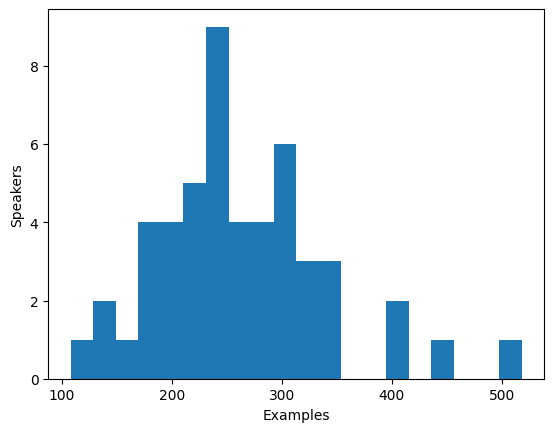

In [80]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [81]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id.split("-")[0]] <= 400


tts_dataset = tts_dataset.filter(select_speaker, input_columns=["id"])

In [82]:
tts_dataset

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 12142
})

### Speaker Embedding

In [83]:
import os
import torch
from speechbrain.inference.classifiers import EncoderClassifier

In [84]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"

speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)

In [85]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()

    return speaker_embeddings

### Preprocessing Function

In [86]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

### Testing

In [87]:
processed_example = prepare_dataset(tts_dataset[0])

list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

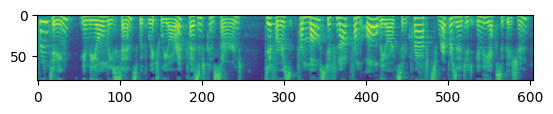

In [88]:
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [89]:
preprocessed_dataset = tts_dataset.map(prepare_dataset, remove_columns=tts_dataset.column_names)

In [90]:
preprocessed_dataset

Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 12142
})

In [91]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

In [92]:
preprocessed_dataset = preprocessed_dataset.filter(is_not_too_long, input_columns=["input_ids"])

In [93]:
preprocessed_dataset

Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 12142
})

In [94]:
preprocessed_dataset = preprocessed_dataset.train_test_split(test_size=0.25)

In [95]:
preprocessed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 9106
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 3036
    })
})

In [96]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )

            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings

        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [97]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

# Model Training

In [98]:
from transformers import SpeechT5ForTextToSpeech

In [99]:
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
model.config.use_cache = False

In [100]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [105]:
training_args = Seq2SeqTrainingArguments(

    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=4,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
)

In [106]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [107]:
trainer.train()
trainer.save_model("/content/drive/MyDrive/hf_tts_model")

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 